In [1]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [2]:
df = pd.read_csv('data/fer2013.csv')



In [3]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [4]:
INTERESTED_LABELS = [0, 3, 4, 6]

df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape # (21264, 3)

(26217, 3)

In [5]:
#convert each flattened image (1D array) into a 3D array with shape (length, width, color channel) 
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

#stack the images in 4D array because we feed data as batches to our model, rather then feeding it one at a time.
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)



(26217, 48, 48, 1)

In [6]:
# encode the labels so we can better train the model. Since the label are not ordinal we enconde using one-hot enconding (0,1) 
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape # (21264, 3)


(26217, 4)

In [7]:

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping # {3: 0, 4: 1, 6: 2} {0: 0, 3: 1, 4: 2, 6: 3}

{0: 0, 3: 1, 4: 2, 6: 3}

In [8]:
#suffling: split data into random order to remove inherent order or patterns in it. this ensures the data is evenly distributed
#stratification: divides the data into homogeneous subgroups based on a characteristics (e.g. labels). 
  #this ensures that the proportion of the different classes in the dataset is maintained in both the training and the validation sets  
  #this reduces the overfiting to a particular class/label.
  #stratify means to maintain the proportion of different classes when splitting a dataset into training and validation sets. 

X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

del df
del img_array
del img_labels

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


(23595, 48, 48, 1) (2622, 48, 48, 1) (23595, 4) (2622, 4)


In [9]:
#Neural Networks are very sensitive to non-normalized data. 
#Use minmax normalization 
#For these gray-scaled images min=0, max=255 therefore we will divide the array by 255 because,

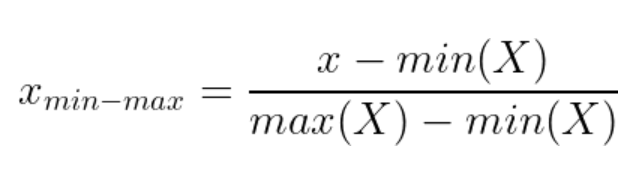

In [10]:
# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


In [11]:
print(img_width)
print(img_height)
print(img_depth)
print(num_classes)

48
48
1
4


## Create Img Recognition Model
Options:
1. CNN: convolutional neural network. Commonly used for img rec. 
2. SVMs: support Vector Machines. More complex hyperparameters
3. RNN: recurrent neural networks. commonly used for video frames. 

Find the best model by using hyperparameter tuning such as gridsearch or random_search 

In [12]:
#Create deep convolutional neural network (DCNN) model.
def build_net(optim):

    """
        Builds a deep convolutional neural network (DCNN) with multiple convolutional, 
        max pooling, batch normalization, and dropout layers.

        Args:
        - optim: an optimizer object that will be used during training to minimize 
        the loss function.

        Returns:
        - A compiled DCNN model that is ready to be trained on image classification tasks.
        """

    #create Sequential Model 
    net = Sequential(name='DCNN')

    # adds a 2D conv layer to the Model
        #64 filters: can extract 64 layers of features from an img
        # kernel: the layer will scan every 5x5 pixel window of an img
        # input_shape: the dimension of the input img. height, width, depth. 
        # elu: applied to the output. allows for negative values to pass through the neural networks without being ignored
            # ELU avoids the dying ReLU problems where neuros can become 'dead' and decrease in accuracy
            # Elu has shown to achieve better performance then relu, including the Fer2012 providing smoother representation power
        #he_normal: ensures the layers are initialized in a way that fit neural networks
        #conv2d_1: name of the Conv for later usage
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    # Batchnormalization: standardizes the input layers for each batch during training
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    # Maxpooling: reduces the size of the output 
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))

    #Dropout: Used to prevent overfitting. Helps to prevent the network from relying too heavily in one feature
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
    
    # Dense: activation function that allows the network to learn the relationships between input and output.
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [13]:
#Callbacks: special functions that are called during the training at varios points. 
    # Use to perform certain action like, saving the best model, adjusting learning rate, etc. 

#Early Stopping: stops the training process if the validation process does not improve after a number of epochs (specified by patience param)
    # threshold for 'improvement'specified in min_delta
    # restore_best_weights: the model will keep the best 'weights' when the training stops
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

#ReduceLROnPlateau: adjust the optimizer when the validation accuracy stops improving 
    #patience: specifies the number of epochs to wait before reducing the learning rate. 
    # 'min_lr': sets a minimum learning rate that can be reached.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)

#var to be passed in the fit() method to be used in the training process
callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [15]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 30

optims = [
  optimizers.Nadam(
      learning_rate=0.001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      name='Nadam'),
    
  optimizers.Adam(0.001),
]

In [16]:
model = build_net(optims[1]) 

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

C:\Users\danid\AppData\Local\Temp\ipykernel_8840\1913433744.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


737/737 [==============================] - 774s 1s/step - loss: 1.6065 - accuracy: 0.3247 - val_loss: 1.2435 - val_accuracy: 0.4619 - lr: 0.0010
Epoch 2/30
737/737 [==============================] - 870s 1s/step - loss: 1.2947 - accuracy: 0.4037 - val_loss: 1.1221 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 3/30
737/737 [==============================] - 895s 1s/step - loss: 1.1735 - accuracy: 0.4698 - val_loss: 1.4303 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 4/30
737/737 [==============================] - 939s 1s/step - loss: 1.0750 - accuracy: 0.5267 - val_loss: 1.0235 - val_accuracy: 0.5614 - lr: 0.0010
Epoch 5/30
737/737 [==============================] - 967s 1s/step - loss: 1.0071 - accuracy: 0.5706 - val_loss: 0.8880 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 6/30
737/737 [==============================] - 895s 1s/step - loss: 0.9545 - accuracy: 0.5974 - val_loss: 0.8230 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 7/30
737/737 [==============================] - 829s 1s/step - loss: 

In [17]:
model.save("data/cnn_model.h5")
import pickle
with open('data/cnn_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_5
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_6
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\dense
.

### Let's plot the results for analysis

##### ps: accuracy vs validation_accuracy
*accuracy*: how well my model is predicting. Metric for evaluation of model.  
*validation_accuracy*: how well my model can make predictions for new data. The accuracy on the validation (test) part of the dataset. 

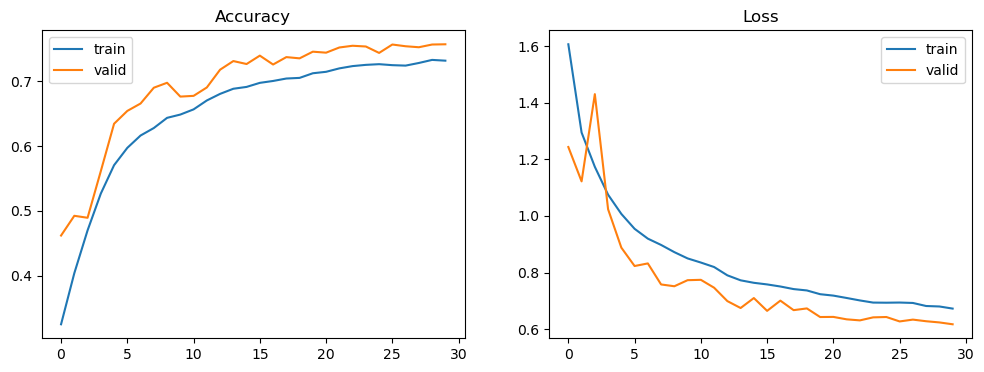

In [18]:
fig = pyplot.figure(0, (12, 4))

# Create a subplot for the accuracy plot
ax = pyplot.subplot(1, 2, 1)

# Plot the training and validation accuracy on the same plot
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train', ax=ax)
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid', ax=ax)
pyplot.title('Accuracy')

# Create a subplot for the loss plot
ax = pyplot.subplot(1, 2, 2)

# Plot the training and validation loss on the same plot
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train', ax=ax)
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid', ax=ax)
pyplot.title('Loss')

pyplot.show()


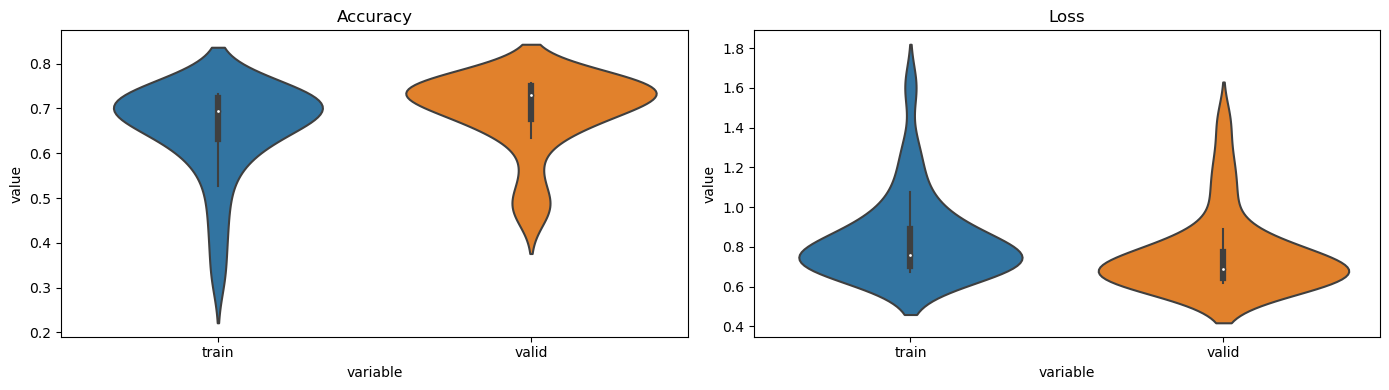

In [19]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

82/82 [==============================] - 31s 383ms/step


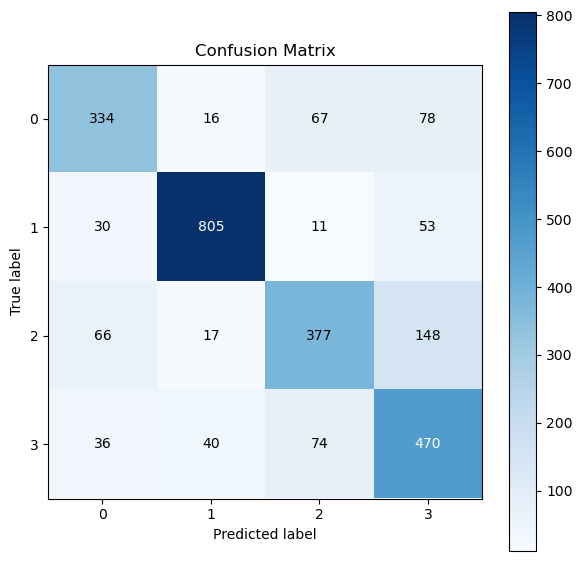

In [21]:
yhat_valid = model.predict(X_valid)
yhat_valid_multiclass = np.argmax(yhat_valid, axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid_multiclass, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")



In [29]:
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid_multiclass)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid_multiclass))

total wrong validation predictions: 636


              precision    recall  f1-score   support

           0       0.72      0.67      0.70       495
           1       0.92      0.90      0.91       899
           2       0.71      0.62      0.66       608
           3       0.63      0.76      0.69       620

    accuracy                           0.76      2622
   macro avg       0.74      0.74      0.74      2622
weighted avg       0.76      0.76      0.76      2622



1/1 [==============================] - 0s 67ms/step


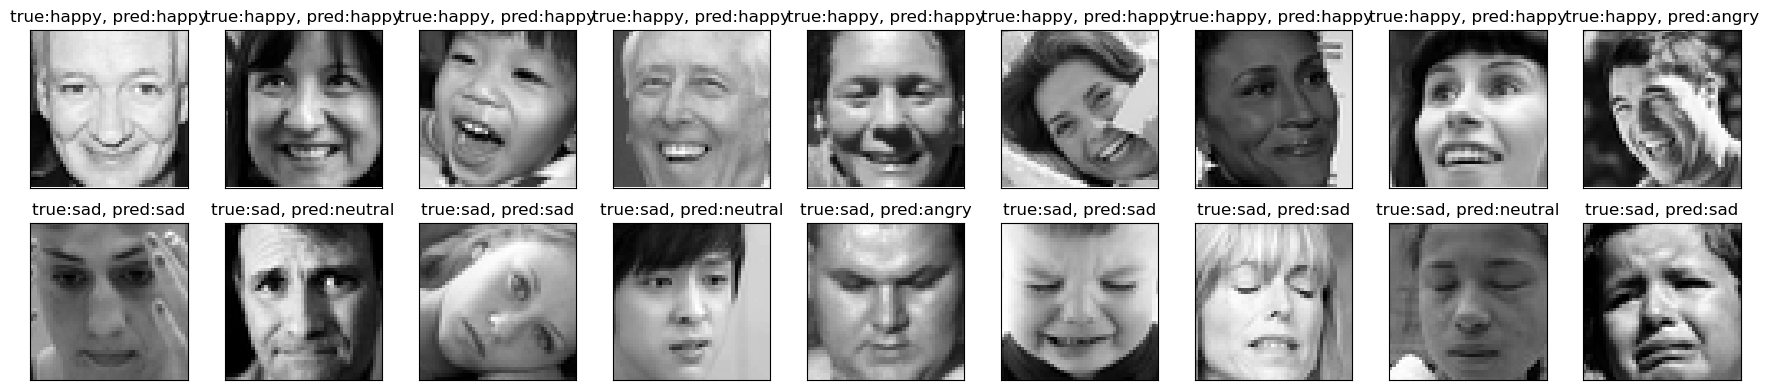

In [32]:
mapper = {
    0: "angry",
    1: "happy",
    2: "sad",
    3: 'neutral'
}

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:happy, pred:{mapper[model.predict(sample_img.reshape(1,48,48,1)).argmax()]}")


        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict(sample_img.reshape(1,48,48,1)).argmax()]}")
        pyplot.tight_layout()